<h1 style="font-size:2.2em; font-weight:bold; text-align:center;">Feature Engineering</h1>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/EDA_nordic_transactions_with_fraud.csv')

In [3]:
df.drop(['Unnamed: 0'], inplace=True, axis=1)
df.head()

,transaction_id,transaction_date,booking_date,value_date,payment_date,amount,currency,from_account_id,from_account_name,counterparty_account_id,...,from_account_expected_turnover,amount_eur,transaction_day,transaction_mon,booking_day,booking_mon,value_day,value_mon,payment_day,payment_mon
0,1d8bdb66-975b-4441-8b85-b96727eaf2ec,2025-11-06,2025-11-08,2025-11-09,2025-11-11,203701.64,NOK,GB74RNID44875257607090,"Rodriguez, Myers and Giles",GB59UNYK99322750860913,...,1021011.83,17689.450418,6,11,8,11,9,11,11,11
1,84b060bf-10a8-470d-8f8a-509a60c97a82,2025-04-19,2025-04-21,2025-04-21,2025-04-22,427642.34,SEK,GB61JXRV87150476031654,"Hensley, Brandt and Mckenzie",GB06AOZA90321060059678,...,1491544.84,39419.490252,19,4,21,4,21,4,22,4
2,f94387bf-0550-44bf-a3ab-fd853f9f886c,2025-04-09,2025-04-11,2025-04-11,2025-04-12,464717.51,NOK,GB12IOQU60716165244897,Newton LLC,GB89BCSP82436524967772,...,1967002.12,40356.068568,9,4,11,4,11,4,12,4
3,8185f0fb-960a-4be3-bd7f-11c3169c9ed7,2025-06-12,2025-06-14,2025-06-14,2025-06-15,265887.72,DKK,GB57OMHZ93858433256887,Frye Ltd,GB98VFPC29413119107640,...,1017836.10,35639.589989,12,6,14,6,14,6,15,6
4,f27edb54-08cc-4604-ba95-9b36a1bc48d7,2025-07-18,2025-07-20,2025-07-20,2025-07-21,376947.00,NOK,GB23JEMB99152786535417,Contreras-Baker,GB36FLGI40138482504680,...,456226.44,32734.077480,18,7,20,7,20,7,21,7


## <h2 style="font-size: 1.6em; font-weight: bold;"> 1. Handling Missing Values </h2>

In [4]:
#First, start with categorical features.
feature_na = [feature for feature in df.columns 
              if df[feature].isnull().sum()>1 and df[feature].dtypes == 'O']
feature_na

['counterparty_name',
 'narrative',
 'related_trade_invoice_id',
 'end_to_end_identification',
 'from_account_business_type']

In EDA, we found that only `related_trade_invoice_id` is related to `is_fraud`, so we will handle this column separately.

In [5]:
#Drop other columns not related to the target variable.
for feature in feature_na: 
    if feature != 'related_trade_invoice_id':
      df[feature_na] = df[feature_na].fillna(0)
    else: 
     df[feature_na] = df[feature_na].fillna ('missing')
df.isnull().sum()

transaction_id                    0
transaction_date                  0
booking_date                      0
value_date                        0
payment_date                      0
amount                            0
currency                          0
from_account_id                   0
from_account_name                 0
counterparty_account_id           0
counterparty_name                 0
counterparty_country              0
counterparty_bank_bic             0
counterparty_business_type        0
narrative                         0
payment_purpose_code              0
related_trade_invoice_id          0
swift_message_type                0
transaction_status                0
transaction_type_description      0
end_to_end_identification         0
is_fraud                          0
from_account_country              0
from_account_business_type        0
from_account_expected_turnover    0
amount_eur                        0
transaction_day                   0
transaction_mon             

In this project, there are no missing numeric values. But if there were, we’d use the median or mode to fill them in, since we found outliers during EDA.

## <h2 style="font-size: 1.6em; font-weight: bold;"> 2. New Features Creation </h2>

**Numeric Features**

`turnover_jump_pct`

Calculate the Turnover Jump % to spot any unusual spikes in transaction volumes that could indicate suspicious activity.

In [6]:
df.rename(columns={'from_account_expected_turnover': 'expected_turnover'}, inplace=True) 
df['turnover_jump_pct'] = (100.00* df['amount_eur']/ df['expected_turnover']).round(2)
len(df.loc[df['turnover_jump_pct'] > 100.00])

407

We found 407 transactions with a turnover jump percentage over 100%.

`risky_flag`

Flag all transactions sent to risky countries (as defined by sanctions and potential tariff threats)

In [7]:
risky_countries = ['HK', 'SG', 'CN', 'RU']

df['is_rirsk _country'] = df['counterparty_country'].isin(risky_countries).astype(int)

count_countries_flag = (df['is_rirsk _country'] == 1).sum()
count_countries_flag

3010

We found 3,010 transactions sent to risky countries.

`split_payment`

To flag `split_payment`, we applied business rules to identify accounts that show any of these signs:

- Made multiple payments within a single day.

- Had repeated or similar transaction amounts

- Made more than a set number of payments (high frequency).

In [8]:
# Case 1: Made multiple payments within a single day
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
time_diff = df.groupby('from_account_name')['transaction_date'].diff()
df['is_sequential']= (time_diff <= pd.Timedelta(days=1)).astype(int)

# Case 2: Had repeated or similar transaction amounts
df['is_repeated_amount'] = df.groupby('from_account_name')['amount_eur'].transform(
    lambda x: x.duplicated(keep=False)
).astype(int)

# Case 3: Made more than 3 payments (high frequency)
txn_count = df.groupby('from_account_name')['transaction_id'].transform('count')
df['is_high_frequency'] = (txn_count >= 3).astype(int)

# Final flag: if any condition is met
df['is_split'] = (df['is_sequential'] | df['is_repeated_amount'] | df['is_high_frequency']
)

count_split_payment = (df['is_split'] ==1).sum()
count_split_payment

1395

We have 1,395 transactions marked as split payments.

## <h2 style="font-size: 1.6em; font-weight: bold;"> 3. Feature Transformation </h2>

**3.1 Continuous Variable**

In [9]:
num_variables = df.select_dtypes(include='float')
num_variables

,amount,expected_turnover,amount_eur,turnover_jump_pct
0,203701.64,1021011.83,17689.450418,1.73
1,427642.34,1491544.84,39419.490252,2.64
2,464717.51,1967002.12,40356.068568,2.05
3,265887.72,1017836.10,35639.589989,3.50
4,376947.00,456226.44,32734.077480,7.17
...,...,...,...,...
10111,95963.60,907524.41,8333.479024,0.92
10112,202629.40,452011.00,18678.102964,4.13
10113,388276.43,539107.08,35790.794119,6.64
10114,230847.17,1251864.81,20046.768243,1.60


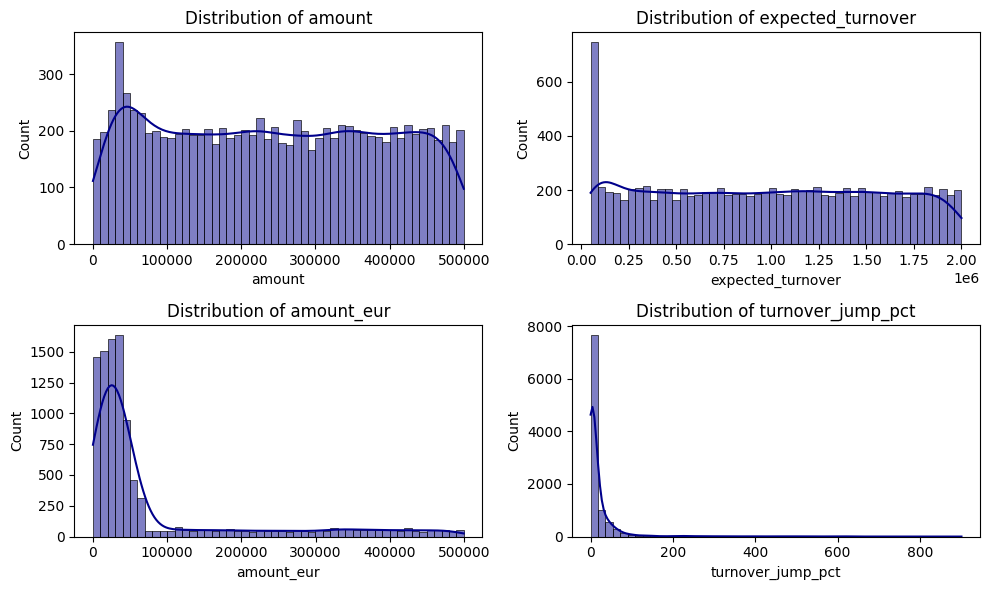

In [10]:
plt.figure(figsize=(10, 6))
for i, col in enumerate(num_variables,1):
      df_copy = df.copy()
      plt.subplot(2, 2, i)
      sns.histplot(df_copy[col], bins=50, kde=True, color='darkblue')
      plt.title(f'Distribution of {col}')
      plt.xlabel(col)
      plt.ylabel('Count')

plt.tight_layout()
plt.show()

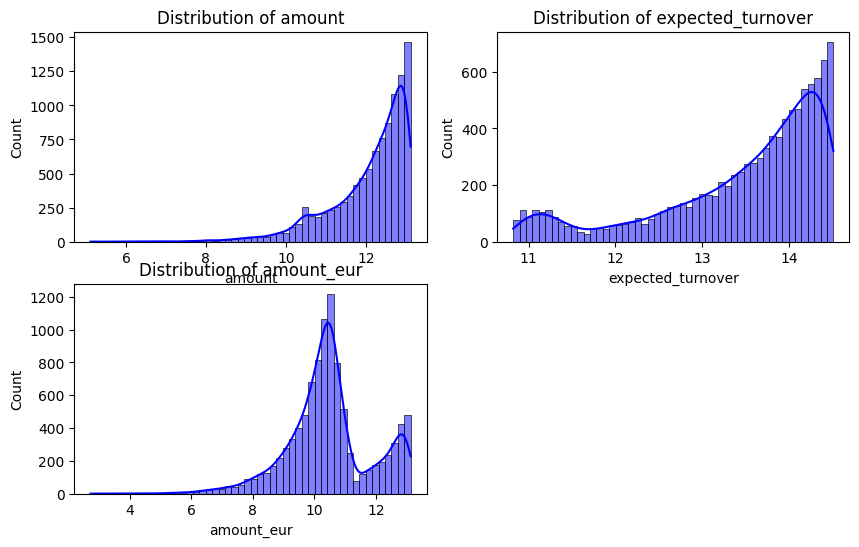

In [11]:
#Let's apply log transformation.
from numpy import log

plt.figure(figsize=(10, 6))
for i, col in enumerate(num_variables,1):
    df_copy=df.copy()
    if 0 in df_copy[col].unique():
        pass
    else:
       df_copy[col] = np.log(df_copy[col])
       plt.subplot(2, 2, i)
       sns.histplot(df_copy[col], bins=50, kde=True, color='blue')
       plt.title(f'Distribution of {col}')
       plt.xlabel(col)
       plt.ylabel('Count')

 

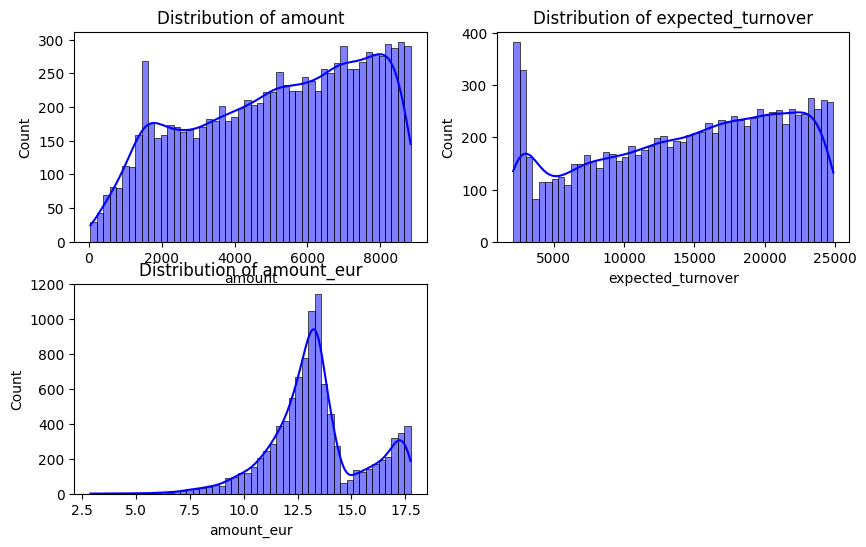

In [12]:
#Try using Box-Cox transformation
from scipy.stats import boxcox

plt.figure(figsize=(10, 6))
for i, col in enumerate(num_variables,1):
    if 0 in df[col].unique():
        pass
    else:
       bc_result,_ = boxcox(df[col])
       plt.subplot(2, 2, i)
       sns.histplot(bc_result, bins=50, kde=True, color='blue')
       plt.title(f'Distribution of {col}')
       plt.xlabel(col)
       plt.ylabel('Count')

It seems Box-Cox performs better than log transformation.

**3.2 Categorical Feature**

In [14]:
categorical_features = df.select_dtypes(include='object')

#Identify the number of unique categories in each categorical (object) column.
for feature in categorical_features: 
    count_value = categorical_features[feature].value_counts()
    print (feature,'-', len(count_value),'categories')


transaction_id - 10116 categories
booking_date - 275 categories
value_date - 276 categories
payment_date - 279 categories
currency - 5 categories
from_account_id - 10116 categories
from_account_name - 8776 categories
counterparty_account_id - 10116 categories
counterparty_name - 8378 categories
counterparty_country - 10 categories
counterparty_bank_bic - 4 categories
counterparty_business_type - 5 categories
narrative - 8826 categories
payment_purpose_code - 5 categories
related_trade_invoice_id - 2880 categories
swift_message_type - 3 categories
transaction_status - 3 categories
transaction_type_description - 4 categories
end_to_end_identification - 5324 categories
from_account_country - 4 categories
from_account_business_type - 6 categories


In [15]:
#Create a drop_col list to remove unnecessary columns.
drop_col = []
date_features = ['booking_date', 'value_date','payment_date']
for feature in categorical_features: 
    count_value = categorical_features[feature].value_counts()
    if len(count_value) == len(df) or feature in date_features:
      drop_col.append(feature)
drop_col.append('transaction_date')
drop_col

['transaction_id',
 'booking_date',
 'value_date',
 'payment_date',
 'from_account_id',
 'counterparty_account_id',
 'transaction_date']

*Rare Categorical Feature*

We will lable 'rare_var' for categorical variables that appear in less than 1% of the observations, as they carry little significance for the analysis.

In [16]:
for feature in categorical_features:
    if feature not in drop_col:
     counts = categorical_features[feature].value_counts()
     rare_categories = counts[counts < len(df) * 0.01].index
     df[feature] = df[feature].apply(lambda x: 'rare_var' if x in rare_categories else x)

*Categorical Feature*

Use Mean encoding to convert categorical variables into numbers based on their relationship with the target variable `is_fraud`.

In [17]:
for feature in categorical_features:
    if feature not in drop_col:
     labels_ordered = df.groupby([feature])['is_fraud'].mean().sort_values().index
     labels_ordered = {k: i for i, k in enumerate(labels_ordered, 0)}
     df[feature] = df[feature].map(labels_ordered)

In [18]:
df.head()

,transaction_id,transaction_date,booking_date,value_date,payment_date,amount,currency,from_account_id,from_account_name,counterparty_account_id,...,value_day,value_mon,payment_day,payment_mon,turnover_jump_pct,is_rirsk _country,is_sequential,is_repeated_amount,is_high_frequency,is_split
0,1d8bdb66-975b-4441-8b85-b96727eaf2ec,2025-11-06,2025-11-08,2025-11-09,2025-11-11,203701.64,1,GB74RNID44875257607090,0,GB59UNYK99322750860913,...,9,11,11,11,1.73,0,0,0,0,0
1,84b060bf-10a8-470d-8f8a-509a60c97a82,2025-04-19,2025-04-21,2025-04-21,2025-04-22,427642.34,3,GB61JXRV87150476031654,0,GB06AOZA90321060059678,...,21,4,22,4,2.64,0,0,0,0,0
2,f94387bf-0550-44bf-a3ab-fd853f9f886c,2025-04-09,2025-04-11,2025-04-11,2025-04-12,464717.51,1,GB12IOQU60716165244897,0,GB89BCSP82436524967772,...,11,4,12,4,2.05,0,0,0,0,0
3,8185f0fb-960a-4be3-bd7f-11c3169c9ed7,2025-06-12,2025-06-14,2025-06-14,2025-06-15,265887.72,0,GB57OMHZ93858433256887,0,GB98VFPC29413119107640,...,14,6,15,6,3.50,0,0,0,1,1
4,f27edb54-08cc-4604-ba95-9b36a1bc48d7,2025-07-18,2025-07-20,2025-07-20,2025-07-21,376947.00,1,GB23JEMB99152786535417,0,GB36FLGI40138482504680,...,20,7,21,7,7.17,0,0,0,0,0


## <h2 style="font-size: 1.6em; font-weight: bold;"> 4. Feature Scaling </h2>

In [19]:
from sklearn.preprocessing import MinMaxScaler

feature_scale = [feature for feature in df.columns if feature not in drop_col and feature!='is_fraud']
scaler = MinMaxScaler()
scaler.fit(df[feature_scale])

scaler.transform(df[feature_scale])

data = pd.concat([df[drop_col + ['is_fraud']].reset_index(drop=True),
    pd.DataFrame(scaler.transform(df[feature_scale]), columns=feature_scale)
], axis=1)

data.head().T

,0,1,2,3,4
transaction_id,1d8bdb66-975b-4441-8b85-b96727eaf2ec,84b060bf-10a8-470d-8f8a-509a60c97a82,f94387bf-0550-44bf-a3ab-fd853f9f886c,8185f0fb-960a-4be3-bd7f-11c3169c9ed7,f27edb54-08cc-4604-ba95-9b36a1bc48d7
booking_date,2025-11-08,2025-04-21,2025-04-11,2025-06-14,2025-07-20
value_date,2025-11-09,2025-04-21,2025-04-11,2025-06-14,2025-07-20
payment_date,2025-11-11,2025-04-22,2025-04-12,2025-06-15,2025-07-21
from_account_id,GB74RNID44875257607090,GB61JXRV87150476031654,GB12IOQU60716165244897,GB57OMHZ93858433256887,GB23JEMB99152786535417
counterparty_account_id,GB59UNYK99322750860913,GB06AOZA90321060059678,GB89BCSP82436524967772,GB98VFPC29413119107640,GB36FLGI40138482504680
transaction_date,2025-11-06 00:00:00,2025-04-19 00:00:00,2025-04-09 00:00:00,2025-06-12 00:00:00,2025-07-18 00:00:00
is_fraud,0,0,0,0,0
amount,0.407323,0.855481,0.929677,0.531772,0.754028
currency,0.25,0.75,0.25,0.0,0.25


In [21]:
data.to_csv('data/CLEAN_nordic_transactions_with_fraud.csv')